<a href="https://colab.research.google.com/github/narhelmi/Hyperparameter_optimization_narges/blob/main/Hyperpparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91353    0 91353    0     0   263k      0 --:--:-- --:--:-- --:--:--  263k
Archive:  wine+quality.zip
  inflating: winequality-red.csv     
  inflating: winequality-white.csv   
  inflating: winequality.names       
sample_data  winequality.names	winequality-red.csv  winequality-white.csv  wine+quality.zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulf

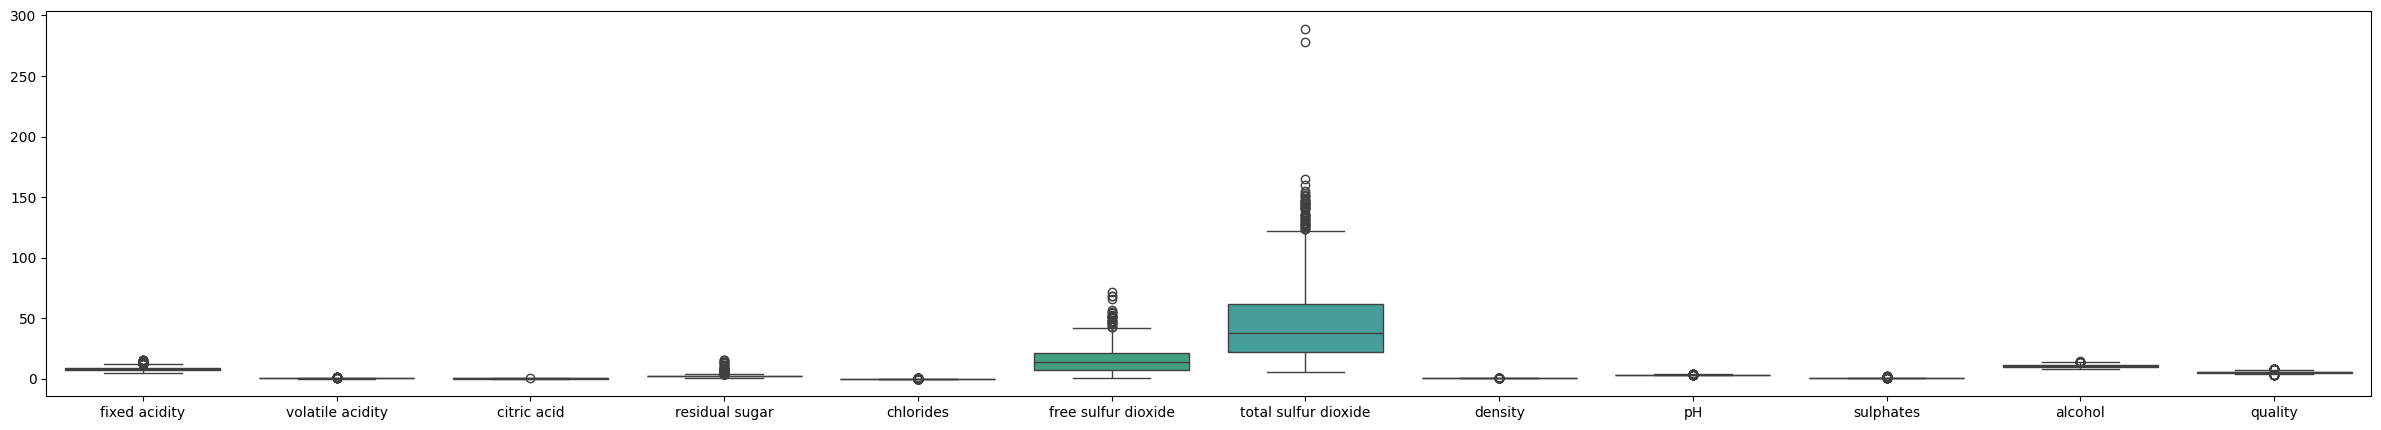

....................................................................................................
Random Forest
 Best Params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 100}


....................................................................................................
Gradient Boosting
 Best Params: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}
....................................................................................................
Decision Tree
 Best Params: {'min_samples_split': 100, 'min_samples_leaf': 3, 'max_depth': 100}
....................................................................................................


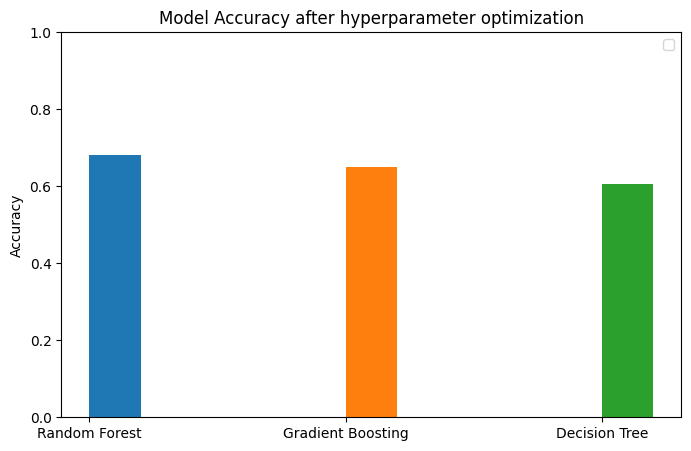

               Model Data Type  Accuracy
0      Random Forest    Scaled   0.68125
1  Gradient Boosting    Scaled   0.65000
2      Decision Tree    Scaled   0.60625


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

# Download dataset
!curl https://archive.ics.uci.edu/static/public/186/wine+quality.zip -O -J -L && unzip -o wine+quality.zip
!ls

# Load the dataset
path = './winequality-red.csv'
df = pd.read_csv(path, delimiter=';')

# Display dataset
print(df.info())
print(df.sample())


plt.figure(figsize=(30, 5))
sns.boxplot(data=df)
plt.show()

# Data preprocessing
feature = df.drop('quality', axis=1)
target = df['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.1, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter search space
param_distributions = {


    'Random Forest': {
        'n_estimators': (100, 1000),
        'max_depth': (3,100),
        'min_samples_split': (2,100),
        'min_samples_leaf': (1, 4)
    },
    'Gradient Boosting': {
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 1),
        'max_depth': (3, 100),
    },
    'Decision Tree': {
        'max_depth': (3,100),
        'min_samples_split': (3, 100),
        'min_samples_leaf': (3, 100)
    }
}

# Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}


data_types = {

    'Scaled': (X_train_scaled, X_test_scaled)
}

# best parameters
def evaluate_models(models, param_distributions, data_types, n_iter=8, cv=3):
    results = {
        'Model': [],
        'Data Type': [],
        'Accuracy': [],
        'Best Params': []
    }

    best_params = {}

    for model_name, model in models.items():
        for data_type, (X_train_set, X_test_set) in data_types.items():
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_distributions[model_name],
                n_iter=n_iter,
                scoring='accuracy',
                n_jobs=-1,
                cv=cv,
                random_state=42,
                error_score='raise'
            )
            try:
                random_search.fit(X_train_set, y_train)
                best_model = random_search.best_estimator_
                y_pred = best_model.predict(X_test_set)
                accuracy = accuracy_score(y_test, y_pred)

                results['Model'].append(model_name)
                results['Data Type'].append(data_type)
                results['Accuracy'].append(accuracy)
                results['Best Params'].append(random_search.best_params_)

                best_params[(model_name, data_type)] = random_search.best_params_

                print(100 * '.')
                print(f"{model_name}")
                print(f" Best Params: {random_search.best_params_}")
            except Exception as e:
                print(f"Error with {model_name} for {data_type}: {e}")

    return results, best_params

# Evaluate models and best parameters
results, best_params = evaluate_models(models, param_distributions, data_types)
results_df = pd.DataFrame(results)

print(100 * '.')
# Plot the accuracy results
plt.figure(figsize=(8, 5))
bar_width = 0.2

for i, model_name in enumerate(models.keys()):
    scaled_acc = results_df[(results_df['Model'] == model_name) & (results_df['Data Type'] == 'Scaled')]['Accuracy'].values[0]

    plt.bar(i + bar_width/2, scaled_acc, bar_width)

plt.title('Model Accuracy after hyperparameter optimization')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(range(len(models)), models.keys())
plt.legend()
plt.show()

#  models with best parameters and calculate accuracy
def train_and_evaluate_final_models(models, best_params, data_types):
    final_results = {
        'Model': [],
        'Data Type': [],
        'Accuracy': []
    }

    for model_name, model in models.items():
        for data_type, (X_train_set, X_test_set) in data_types.items():
            params = best_params[(model_name, data_type)]
            final_model = model.set_params(**params)
            final_model.fit(X_train_set, y_train)
            y_pred = final_model.predict(X_test_set)
            accuracy = accuracy_score(y_test, y_pred)

            final_results['Model'].append(model_name)
            final_results['Data Type'].append(data_type)
            final_results['Accuracy'].append(accuracy)

    return final_results

# Train and evaluate with best parameters
final_results = train_and_evaluate_final_models(models, best_params, data_types)
final_results_df = pd.DataFrame(final_results)
# Display = results
print(final_results_df)

